<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/DeteksiSarkasme_RNN_LSTM_GRU_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.4 MB/s eta 0:00:00


#Model Deep Learning RNN

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import keras_tuner as kt
import json

In [4]:
# Load dataset
with open('/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json', 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=30, padding='post')
labels = np.array(df['is_sarcastic'])

# Split data
x_train, x_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [5]:
# Model builder
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=10000, output_dim=hp.Choice('embedding_dim', [64, 128, 256]), input_length=30))
    model.add(layers.SimpleRNN(
        units=hp.Choice('rnn_units', [64, 128, 256]),
        return_sequences=False,
        activation='tanh'
    ))
    model.add(layers.Dropout(hp.Choice('dropout', [0.3, 0.4, 0.5])))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
# Tuner dengan RandomSearch yang dibatasi max_trials=5
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Membatasi jumlah percobaan hanya sebanyak 5 kali
    directory='sarcasm_rnn_tuning',
    project_name='rnn_tuner'
)

# Search best hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:\n"
      f"- Embedding dim: {best_hps.get('embedding_dim')}\n"
      f"- RNN units: {best_hps.get('rnn_units')}\n"
      f"- Dropout: {best_hps.get('dropout')}\n"
      f"- Learning rate: {best_hps.get('learning_rate')}")

# Build and train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# Predict probabilities and labels for ROC and classification report
y_probs = model.predict(x_test).flatten()  # Probabilities for AUC
y_pred = (y_probs >= 0.5).astype(int)  # Binary prediction based on threshold of 0.5

Trial 5 Complete [00h 00m 49s]
val_accuracy: 0.5589611530303955

Best val_accuracy So Far: 0.8528310656547546
Total elapsed time: 00h 03m 54s
Best hyperparameters:
- Embedding dim: 256
- RNN units: 64
- Dropout: 0.5
- Learning rate: 0.0005
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6710 - loss: 0.5752 - val_accuracy: 0.8474 - val_loss: 0.3602
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9172 - loss: 0.2202 - val_accuracy: 0.8376 - val_loss: 0.3780
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9603 - loss: 0.1192 - val_accuracy: 0.8470 - val_loss: 0.4454
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9806 - loss: 0.0611 - val_accuracy: 0.8393 - val_loss: 0.5229
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9867 - loss: 0.0410 - val_accuracy: 0.8407 - val_loss: 0.6323
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9883 - loss: 0.0314 - val_accuracy: 0.8336 - val_loss

In [7]:
# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_squared = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

# Training Accuracy (from history)
train_accuracy = history.history['accuracy'][-1]


# Evaluate on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {accuracy:.4f}")

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_squared:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8335 - loss: 0.8343
Final Training Accuracy: 0.9930
Final Testing Accuracy: 0.8347
Precision: 0.8215
Recall: 0.7967
F1 Squared: 0.8089
AUC: 0.9008

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      2996
           1       0.82      0.80      0.81      2346

    accuracy                           0.83      5342
   macro avg       0.83      0.83      0.83      5342
weighted avg       0.83      0.83      0.83      5342



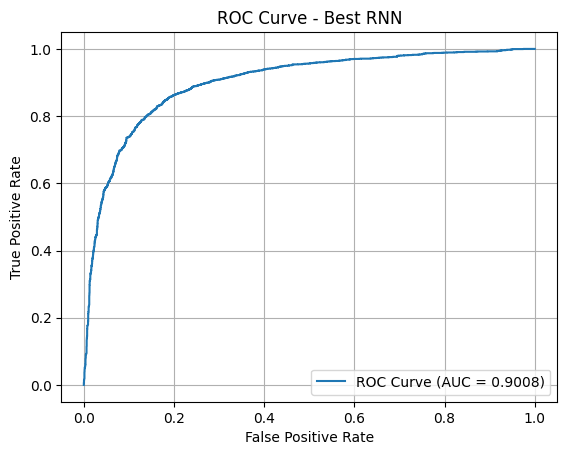

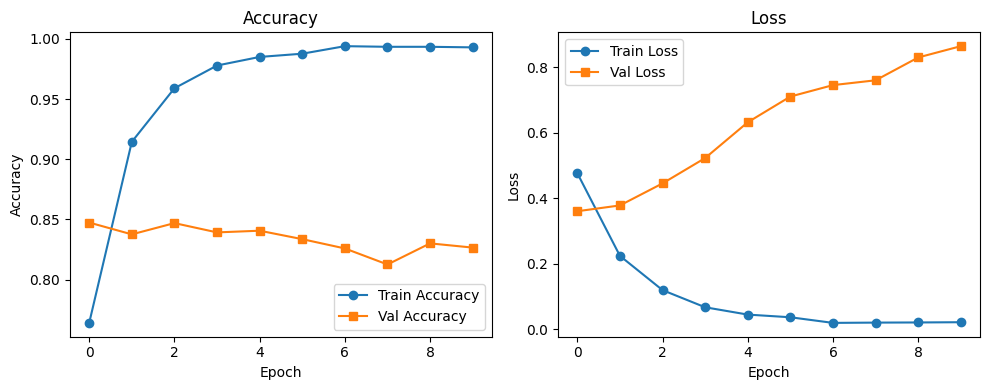

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best RNN')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy & loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Model Deep Learning LSTM

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import keras_tuner as kt
import json

In [10]:
# Load dataset
with open('/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json', 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=30, padding='post')
labels = np.array(df['is_sarcastic'])

# Split data
x_train, x_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [11]:
# Model builder
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=10000, output_dim=hp.Choice('embedding_dim', [64, 128, 256]), input_length=30))
    model.add(layers.LSTM(
        units=hp.Choice('lstm_units', [64, 128, 256]),
        return_sequences=False,
        activation='tanh'
    ))
    model.add(layers.Dropout(hp.Choice('dropout', [0.3, 0.4, 0.5])))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
# Tuner dengan RandomSearch yang dibatasi max_trials=5
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Membatasi jumlah percobaan hanya sebanyak 5 kali
    directory='sarcasm_lstm_tuning',
    project_name='lstm_tuner'
)

# Search best hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:\n"
      f"- Embedding dim: {best_hps.get('embedding_dim')}\n"
      f"- LSTM units: {best_hps.get('lstm_units')}\n"
      f"- Dropout: {best_hps.get('dropout')}\n"
      f"- Learning rate: {best_hps.get('learning_rate')}")

# Build and train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# Predict probabilities and labels for ROC and classification report
y_probs = model.predict(x_test).flatten()  # Probabilities for AUC
y_pred = (y_probs >= 0.5).astype(int)  # Binary prediction based on threshold of 0.5

Trial 5 Complete [00h 00m 56s]
val_accuracy: 0.8530650734901428

Best val_accuracy So Far: 0.8535329699516296
Total elapsed time: 00h 05m 02s
Best hyperparameters:
- Embedding dim: 256
- LSTM units: 256
- Dropout: 0.4
- Learning rate: 0.0005
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6393 - loss: 0.6123 - val_accuracy: 0.8491 - val_loss: 0.3628
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8986 - loss: 0.2645 - val_accuracy: 0.8449 - val_loss: 0.3546
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9402 - loss: 0.1642 - val_accuracy: 0.8421 - val_loss: 0.4250
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9557 - loss: 0.1307 - val_accuracy: 0.8353 - val_loss: 0.4257
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9643 - loss: 0.1165 - val_accuracy: 0.8271 - val_loss: 0.6036
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9734 - loss: 0.0844 - val_accuracy: 0.8341 - val_l

In [15]:
# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_squared = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

# Training Accuracy (from history)
train_accuracy = history.history['accuracy'][-1]


# Evaluate on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {accuracy:.4f}")

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_squared:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8217 - loss: 0.8463
Final Training Accuracy: 0.9845
Final Testing Accuracy: 0.8248
Precision: 0.8147
Recall: 0.7779
F1 Squared: 0.7959
AUC: 0.8991

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85      2996
           1       0.81      0.78      0.80      2346

    accuracy                           0.82      5342
   macro avg       0.82      0.82      0.82      5342
weighted avg       0.82      0.82      0.82      5342



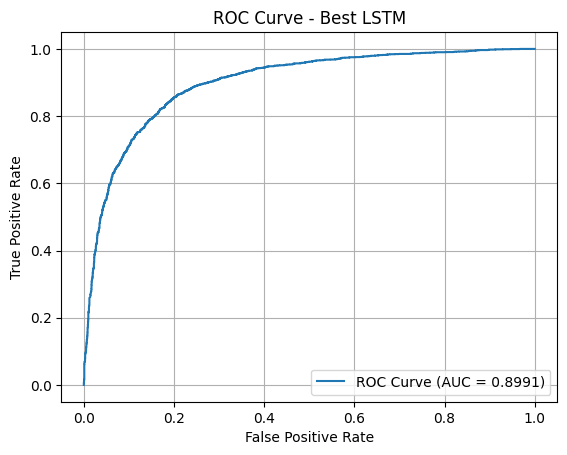

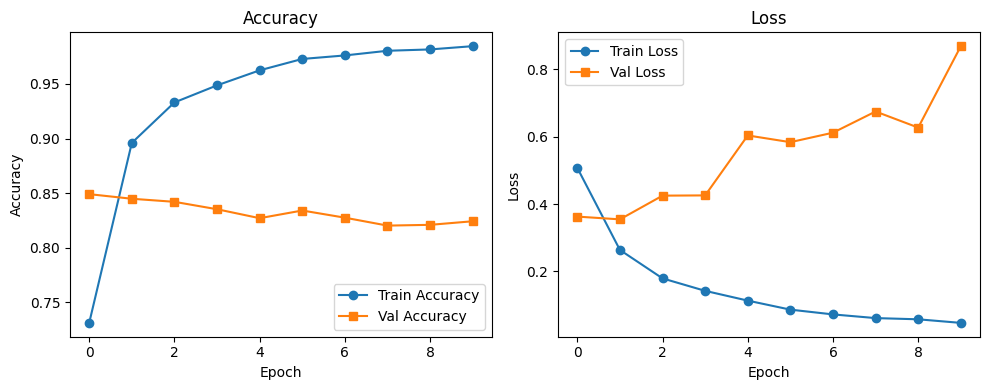

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best LSTM')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy & loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Model Deep Learning GRU

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import keras_tuner as kt
import json

In [18]:
# Load dataset
with open('/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json', 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=30, padding='post')
labels = np.array(df['is_sarcastic'])

# Split data
x_train, x_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

In [19]:
# Model builder for GRU
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=10000, output_dim=hp.Choice('embedding_dim', [64, 128, 256]), input_length=30))
    model.add(layers.GRU(
        units=hp.Choice('gru_units', [64, 128, 256]),
        return_sequences=False,
        activation='tanh'
    ))
    model.add(layers.Dropout(hp.Choice('dropout', [0.3, 0.4, 0.5])))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [20]:
# Tuner dengan RandomSearch yang dibatasi max_trials=5
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Membatasi jumlah percobaan hanya sebanyak 5 kali
    directory='sarcasm_gru_tuning',
    project_name='gru_tuner'
)

# Search best hyperparameters
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters:\n"
      f"- Embedding dim: {best_hps.get('embedding_dim')}\n"
      f"- GRU units: {best_hps.get('gru_units')}\n"
      f"- Dropout: {best_hps.get('dropout')}\n"
      f"- Learning rate: {best_hps.get('learning_rate')}")

# Build and train best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

# Predict probabilities and labels for ROC and classification report
y_probs = model.predict(x_test).flatten()  # Probabilities for AUC
y_pred = (y_probs >= 0.5).astype(int)  # Binary prediction based on threshold of 0.5

Trial 5 Complete [00h 00m 58s]
val_accuracy: 0.8043987154960632

Best val_accuracy So Far: 0.8584464192390442
Total elapsed time: 00h 04m 20s
Best hyperparameters:
- Embedding dim: 128
- GRU units: 256
- Dropout: 0.4
- Learning rate: 0.0005
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5607 - loss: 0.6862 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5560 - loss: 0.6874 - val_accuracy: 0.5538 - val_loss: 0.6875
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5644 - loss: 0.6853 - val_accuracy: 0.5538 - val_loss: 0.6879
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5740 - loss: 0.6778 - val_accuracy: 0.8198 - val_loss: 0.4054
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8661 - loss: 0.3240 - val_accuracy: 0.8496 - val_loss: 0.3492
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9327 - loss: 0.1878 - val_accuracy: 0.8496 - val_los

In [21]:
# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_squared = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

# Training Accuracy (from history)
train_accuracy = history.history['accuracy'][-1]

# Evaluate on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Testing Accuracy: {accuracy:.4f}")

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_squared:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8333 - loss: 0.7987
Final Training Accuracy: 0.9903
Final Testing Accuracy: 0.8321
Precision: 0.8445
Recall: 0.7570
F1 Squared: 0.7984
AUC: 0.9038

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      2996
           1       0.84      0.76      0.80      2346

    accuracy                           0.83      5342
   macro avg       0.83      0.82      0.83      5342
weighted avg       0.83      0.83      0.83      5342



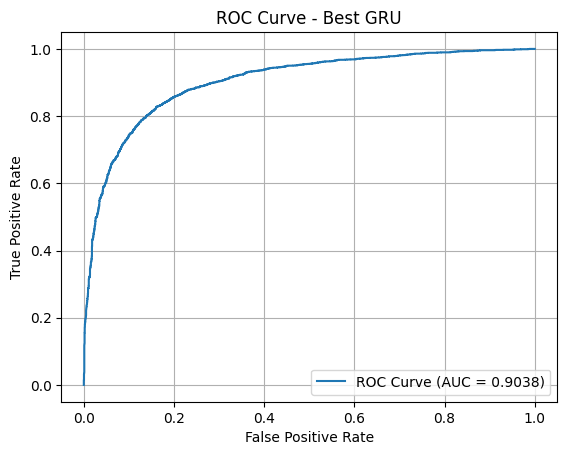

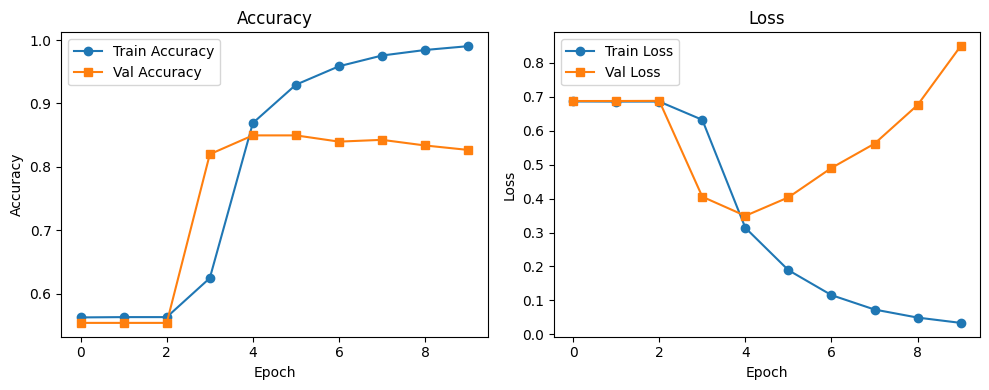

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best GRU')
plt.legend()
plt.grid()
plt.show()



# Plot accuracy & loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 📘 Penjelasan Persamaan Matematika dalam Deep Learning

---

## 🔁 1. Recurrent Neural Network (RNN)

Model RNN mempertimbangkan urutan dengan memori internal:

\[
$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$
\]

- \($ h_t $\): Hidden state saat waktu \($ t $\)
- \($ x_t $\): Input saat waktu \($ t $\)
- \($ W_h, W_x $\): Bobot hidden dan input
- \($ b $\): Bias

---

## 🔒 2. Long Short-Term Memory (LSTM)

LSTM memiliki mekanisme gate untuk menangani long-term dependency:

\[
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \quad \text{(forget gate)} \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \quad \text{(input gate)} \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \quad \text{(candidate state)} \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \quad \text{(cell state)} \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \quad \text{(output gate)} \\
h_t &= o_t * \tanh(C_t) \quad \text{(hidden state)}
\end{aligned}
\]

---

## 🔁 3. Gated Recurrent Unit (GRU)

GRU adalah versi lebih sederhana dari LSTM:

\[
\begin{aligned}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \quad \text{(update gate)} \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \quad \text{(reset gate)} \\
\tilde{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \quad \text{(candidate state)} \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t \quad \text{(new state)}
\end{aligned}
\]

---

## 📉 4. Binary Cross-Entropy Loss

Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

- \($ y_i $\): Label sebenarnya (0 atau 1)
- \($ \hat{y}_i $\): Prediksi model

---

## 🧮 5. Evaluasi Model

**Akurasi:**

\[
$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
\]

Keterangan:
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

**Presisi:**

\[$
\text{Precision} = \frac{TP}{TP + FP}
$\]

**Recall:**

\[$
\text{Recall} = \frac{TP}{TP + FN}
$\]

**F1 Score:**

\[$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$\]

**F1 Squared:**

\[$
F1^2 = (F1)^2
$\]

**AUC (Area Under Curve):** Luas di bawah kurva ROC yang menggambarkan trade-off antara TPR dan FPR.

**ROC Curve:** Grafik yang menunjukkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

---

